# A Toy-Example Using Our Quantum Layer

Adapted from: 
https://github.com/keras-team/keras-io/blob/master/examples/structured_data/structured_data_classification_from_scratch.py
Title: Structured data classification from scratch
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2020/06/09
Last modified: 2020/06/09
Description: Binary classification of structured data including numerical and categorical features.

In [24]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# imports for quantum
import tensorflow_quantum as tfq
import cirq
from cirq import H, X, cphase, CNOT, Z, T
from cirq.circuits import InsertStrategy
import sympy
from cirq.contrib.svg import SVGCircuit

In [25]:
# TFQ / Cirq code for quantum layer: 1 node, input-vector-length = 4
# custom keras layer class
# adapted from https://github.com/ghellstern/QuantumNN/blob/master/Multi-QBit-Classifier%20TF%20NN-Encoding_Github.ipynb
class SplitBackpropQ(tf.keras.layers.Layer):

    def __init__(self, upstream_symbols, managed_symbols, managed_init_vals,
                 operators):
        """Create a layer that splits backprop between several variables.


        Args:
            upstream_symbols: Python iterable of symbols to bakcprop
                through this layer.
            managed_symbols: Python iterable of symbols to backprop
                into variables managed by this layer.
            managed_init_vals: Python iterable of initial values
                for managed_symbols.
            operators: Python iterable of operators to use for expectation.

        """
        super().__init__(SplitBackpropQ)
        self.all_symbols = upstream_symbols + managed_symbols
        self.upstream_symbols = upstream_symbols
        self.managed_symbols = managed_symbols
        self.managed_init = managed_init_vals
        self.ops = operators

    def build(self, input_shape):
        self.managed_weights = self.add_weight(
            shape=(1, len(self.managed_symbols)),
            initializer=tf.constant_initializer(self.managed_init))

    def call(self, inputs):
        # inputs are: circuit tensor, upstream values
        upstream_shape = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_weights = tf.tile(self.managed_weights, [upstream_shape, 1])
        joined_params = tf.concat([inputs[1], tiled_up_weights], 1)
        return tfq.layers.Expectation()(inputs[0],
                                        operators=measurement,
                                        symbol_names=self.all_symbols,
                                        symbol_values=joined_params)


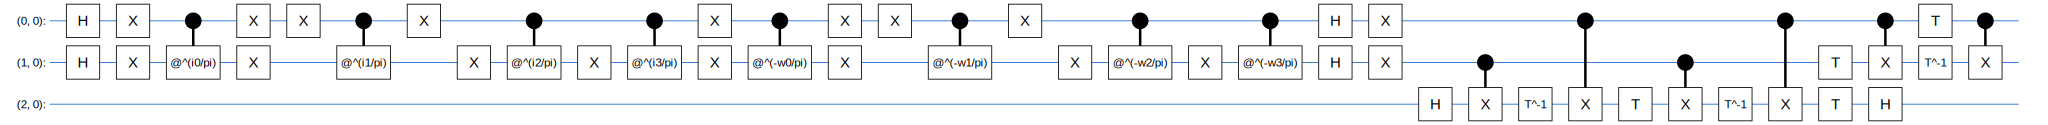

In [26]:
# 2 regular qubits, 1 ancilla
number_qubits = 3
number_regular_qubits = number_qubits - 1

# specify parameters to set later with NN inputs and weights using Keras + TFQ
regular_qubits = [cirq.GridQubit(i, 0) for i in range(number_regular_qubits)]
ancilla = cirq.GridQubit(number_regular_qubits, 0)
control_params = sympy.symbols('i0, i1, i2, i3')
control_params1 = sympy.symbols('w0, w1, w2, w3')

# specify cirq circuit
# TODO: Normalize weights and inputs to be between [0, pi / 2]
qc = cirq.Circuit()
size = len(regular_qubits) ** 2
# apply Hadamard gate to all regular qubits to create a superposition
qc.append(H.on_each(*regular_qubits))
# loop over all inputs in inputvector to encode them to the right base states using phase-shifts
for index in range(size):
    insert_list = []
    # index as binary number
    binary = '{0:02b}'.format(index)
    # get qubit at digit in binary state (positions of qubits : q0, q1, q2, q3) (figuratively, not actually, we are in superposition after all)
    for j in range(len(binary)):
        if binary[j] == '0':
            insert_list.append(X(regular_qubits[j]))
    # perform controlled phase shift (for more qubits probably possible using ControlledGate() and MatrixGate()
    insert_list.append(cphase(control_params[index])(*regular_qubits))
    # "undo" the NOT-gates to get back to previous states = apply another not
    for j in range(len(binary)):
        if binary[j] == '0':
            insert_list.append(X(regular_qubits[j]))
    qc.append(insert_list, strategy=InsertStrategy.NEW_THEN_INLINE)
# loop over weights
for w in range(size):
    insert_list = []
    # index as binary number
    binary = '{0:02b}'.format(w)
    # get qubit at digit in binary state (positions of qubits : q0, q1, q2, q3) (figuratively, not actually, we are in superposition after all)
    for j in range(len(binary)):
        if binary[j] == '0':
            insert_list.append(X(regular_qubits[j]))
    # perform conjugate transpose controlled phase shift
    insert_list.append(cphase((-1) * control_params1[w])(*regular_qubits))
    # "undo" the NOT-gates to get back to previous states = apply another not
    for j in range(len(binary)):
        if binary[j] == '0':
            insert_list.append(X(regular_qubits[j]))
    qc.append(insert_list, strategy=InsertStrategy.NEW_THEN_INLINE)
# apply Hadamard gate to all regular qubits
qc.append(H.on_each(*regular_qubits), strategy=InsertStrategy.NEW_THEN_INLINE)
# apply X gate to all regular qubits
qc.append(X.on_each(*regular_qubits), strategy=InsertStrategy.NEW_THEN_INLINE)
# collect combined state from all regular qubits with ancilla qubit using Toffoli-Gate
# Toffoli-Gate does not work in TFQ -> implement decomposition (compare https://en.wikipedia.org/wiki/Toffoli_gate#/media/File:Qcircuit_ToffolifromCNOT.svg)
qc.append([H(ancilla), CNOT(regular_qubits[1], ancilla), cirq.inverse(T(ancilla)), CNOT(regular_qubits[0], ancilla), T(ancilla), CNOT(regular_qubits[1], ancilla), cirq.inverse(T(ancilla)), CNOT(regular_qubits[0], ancilla), T(ancilla), T(regular_qubits[1]), H(ancilla), CNOT(regular_qubits[0], regular_qubits[1]), cirq.inverse(T(regular_qubits[1])), T(regular_qubits[0]), CNOT(regular_qubits[0], regular_qubits[1])], strategy=InsertStrategy.NEW_THEN_INLINE)
# draw circuit
SVGCircuit(qc)
# end circuit

In [27]:
# values to initialize the weights
np.random.seed(seed=69)
int_values = np.random.rand((len(control_params1)))*np.pi

# measure circuit output
measurement = [Z(ancilla)]

In [28]:
# create the neural network model

# This is needed because of Note here:
# https://www.tensorflow.org/quantum/api_docs/python/tfq/layers/Expectation
inputlayer_for_circuit = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

# classical layer
inputlayer = keras.Input(shape=(32,), name="inputlayer")
x = layers.Dense(32, activation="relu")(inputlayer)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4, activation="relu")(x)
x = layers.Dropout(0.5)(x)
# quantum layer
expectation = SplitBackpropQ(control_params, control_params1, int_values, measurement)([inputlayer_for_circuit, x])

model = keras.Model(inputs=[inputlayer_for_circuit, inputlayer], outputs=expectation)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

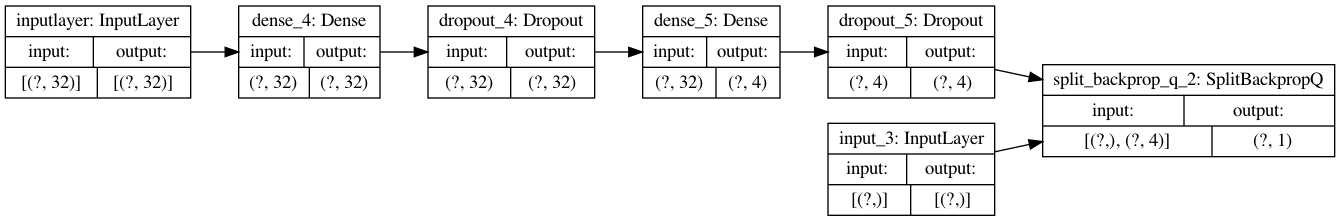

In [29]:
# Visualize our connectivity graph:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [30]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputlayer (InputLayer)         [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           1056        inputlayer[0][0]                 
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 32)           0           dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 4)            132         dropout_4[0][0]                  
_______________________________________________________________________________________

In [31]:
# create the "dataset": network learns to round the average of a row of floats to 0 or to 1
# Training-Dataset:
x_train = []
y_train = []
for _ in range(100):
    x_new = []
    for i in range(32):
        v = np.random.random_sample()
        x_new.append(v)
    x_train.append(x_new)
    y_train.append(np.rint(np.array(x_new).mean()))
x_train = tf.convert_to_tensor(x_train, tf.double)
y_train = tf.convert_to_tensor(y_train, tf.double)

# Validation-Dataset:
x_val = []
y_val = []
for _ in range(100):
    x_new = []
    for i in range(32):
        v = np.random.random_sample()
        x_new.append(v)
    x_val.append(x_new)
    y_val.append(np.rint(np.array(x_new).mean()))
x_val = tf.convert_to_tensor(x_val, tf.double)
y_val = tf.convert_to_tensor(y_val, tf.double)

In [32]:
# Train the model on the dataset
n = x_train.shape[0]
n_val = x_val.shape[0]

model.fit(x=[tfq.convert_to_tensor([qc for _ in range(n)]), x_train], y=y_train, epochs=100, batch_size=32, validation_data=([tfq.convert_to_tensor([qc for _ in range(n_val)]), x_val], y_val), validation_batch_size=32)

Epoch 1/100
4/4 [==============================] - 0s 66ms/step - loss: 5.4205 - accuracy: 0.4700 - val_loss: 2.6612 - val_accuracy: 0.4600
Epoch 2/100
4/4 [==============================] - 0s 31ms/step - loss: 4.3254 - accuracy: 0.5000 - val_loss: 2.6129 - val_accuracy: 0.4600
Epoch 3/100
4/4 [==============================] - 0s 30ms/step - loss: 4.4517 - accuracy: 0.4500 - val_loss: 2.6217 - val_accuracy: 0.4600
Epoch 4/100
4/4 [==============================] - 0s 30ms/step - loss: 4.8081 - accuracy: 0.5500 - val_loss: 2.6049 - val_accuracy: 0.4600
Epoch 5/100
4/4 [==============================] - 0s 36ms/step - loss: 6.0905 - accuracy: 0.5200 - val_loss: 2.5174 - val_accuracy: 0.4700
Epoch 6/100
4/4 [==============================] - 0s 29ms/step - loss: 5.4255 - accuracy: 0.4900 - val_loss: 2.5008 - val_accuracy: 0.4700
Epoch 7/100
4/4 [==============================] - 0s 28ms/step - loss: 4.8010 - accuracy: 0.5300 - val_loss: 2.4748 - val_accuracy: 0.4700
Epoch 8/100
4/4 [===

4/4 [==============================] - 0s 32ms/step - loss: 2.9438 - accuracy: 0.4600 - val_loss: 0.7755 - val_accuracy: 0.4700
Epoch 60/100
4/4 [==============================] - 0s 30ms/step - loss: 2.0591 - accuracy: 0.5500 - val_loss: 0.7722 - val_accuracy: 0.4900
Epoch 61/100
4/4 [==============================] - 0s 29ms/step - loss: 1.4948 - accuracy: 0.5500 - val_loss: 0.7662 - val_accuracy: 0.4800
Epoch 62/100
4/4 [==============================] - 0s 31ms/step - loss: 2.7165 - accuracy: 0.5100 - val_loss: 0.7616 - val_accuracy: 0.5000
Epoch 63/100
4/4 [==============================] - 0s 28ms/step - loss: 2.5680 - accuracy: 0.4800 - val_loss: 0.7712 - val_accuracy: 0.4700
Epoch 64/100
4/4 [==============================] - 0s 36ms/step - loss: 2.1695 - accuracy: 0.4200 - val_loss: 0.7818 - val_accuracy: 0.4600
Epoch 65/100
4/4 [==============================] - 0s 32ms/step - loss: 2.1627 - accuracy: 0.5200 - val_loss: 0.7870 - val_accuracy: 0.4500
Epoch 66/100
4/4 [========

In [33]:
# Predict a sample output
sample = tf.convert_to_tensor([[np.random.random_sample() for _ in range(32)]], tf.double)
predictions = model.predict([tfq.convert_to_tensor([qc]), sample])

print("\n For sample \n" + str(sample) + "\n the predicted label is " + str(predictions) + ".\n It should be " + str(np.rint(np.array(sample[0]).mean())) + ".")


 For sample 
tf.Tensor(
[[0.36276975 0.62228649 0.91612862 0.44844038 0.06016593 0.1523372
  0.61567873 0.61648246 0.18726699 0.57455826 0.91561434 0.22930108
  0.07717578 0.27398852 0.18794287 0.38576981 0.21156043 0.19015982
  0.74203511 0.09382504 0.0087642  0.28001217 0.73518294 0.71676893
  0.44091851 0.04274955 0.92501088 0.50425791 0.82832747 0.12404221
  0.03726142 0.44141035]], shape=(1, 32), dtype=float64)
 the predicted label is [[0.6246433]].
 It should be 0.0.
